In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common import results_plotter
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor




# PPO

## Create Callback

In [6]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

## Plot Functions

In [7]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    #y = moving_average(y, window=50)
    # Truncate x
    #x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

## Normal parameters

In [8]:
# Create environment
env = gym.make("CarRacing-v2")

In [9]:
#setup callback

# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Wrap the environment
env = Monitor(env, log_dir)

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

### Train agent

In [60]:
# Instantiate the agent
model = PPO("MlpPolicy", env, verbose=1)
# Train the agent and display a progress bar
timesteps = 10000
model.learn(total_timesteps=int(timesteps), callback=callback)


Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -56.04
Saving new best model to tmp/best_model.zip
Num timesteps: 2000
Best mean reward: -56.04 - Last mean reward per episode: -55.84
Saving new best model to tmp/best_model.zip
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -55.8    |
| time/              |          |
|    fps             | 36       |
|    iterations      | 1        |
|    time_elapsed    | 56       |
|    total_timesteps | 2048     |
---------------------------------
Num timesteps: 3000
Best mean reward: -55.84 - Last mean reward per episode: -53.49
Saving new best model to tmp/best_model.zip
Num timesteps: 4000
Best mean reward: -53.49 - Last mean reward per episode: -53.02
Saving new best model to tmp/best_model.zip
------------------------------------------
| rollout/    

In [61]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=5)

In [62]:
print(mean_reward, std_reward)

-28.2754988 11.362994076963753


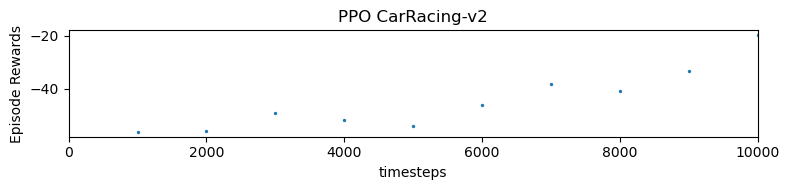

In [64]:
# Helper from the library
results_plotter.plot_results(
    [log_dir], timesteps, results_plotter.X_TIMESTEPS, "PPO CarRacing-v2"
)

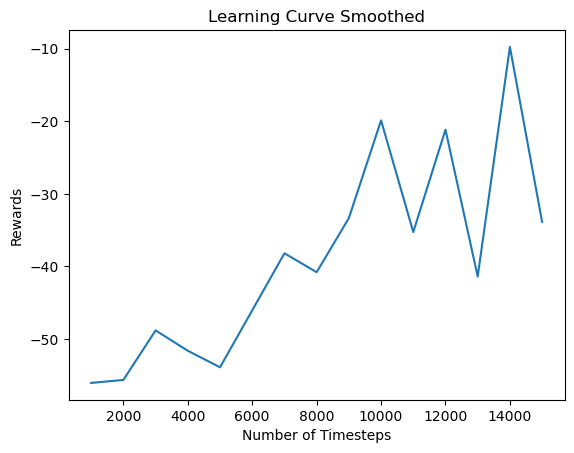

In [74]:
plot_results(log_dir)

### Load pre-trained model

In [80]:
test_env = gym.make("CarRacing-v2", render_mode='human')
dir = log_dir + "best_model"
model = PPO.load("ppo_car", env=test_env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [76]:
vec_env = model.get_env()
obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = vec_env.step(action)
    #obs, rewards, dones, info = test_env.step(action)
    vec_env.render()
    if done:
        break

vec_env.close()

In [10]:
test_env = gym.make("CarRacing-v2", render_mode='rgb_array')
dir = log_dir + "best_model"
model = PPO.load("ppo_car", env=test_env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [11]:
import imageio
import numpy as np
from stable_baselines3 import A2C

model = A2C.load("ppo_car", env=test_env)
images = []

vec_env = model.get_env()
obs = vec_env.reset()
#obs = model.env.reset()
img = vec_env.render()
for i in range(350):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = vec_env.render(mode='rgb_array')

imageio.mimsave('lander_a2c.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


## Discrete space

In [3]:
# Create environment
env = gym.make("CarRacing-v2", continuous=False)

### Train agent

In [4]:
# Instantiate the agent
model = PPO("MlpPolicy", env, verbose=1)
# Train the agent and display a progress bar
model.learn(total_timesteps=int(1000))
# Save the agent
model.save("ppo_car_discrete")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -57.1    |
| time/              |          |
|    fps             | 29       |
|    iterations      | 1        |
|    time_elapsed    | 69       |
|    total_timesteps | 2048     |
---------------------------------


In [5]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

In [6]:
print(mean_reward, std_reward)

-18.244713 59.37324067176865


### Load pre-trained model

In [9]:
test_env = gym.make("CarRacing-v2", render_mode='human', continuous=False)
model = PPO.load("ppo_car_discrete", env=test_env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [10]:
vec_env = model.get_env()
obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = vec_env.step(action)
    #obs, rewards, dones, info = test_env.step(action)
    vec_env.render()
    if done:
        break

vec_env.close()

## Lap completion percentage change 

In [ ]:
# Create environment
env = gym.make("CarRacing-v2", lap_complete_percentage=0.5)

### Train agent

In [ ]:
# Instantiate the agent
model = PPO("MlpPolicy", env, verbose=1)
# Train the agent and display a progress bar
model.learn(total_timesteps=int(1000))
# Save the agent
model.save("ppo_car_reward")

In [ ]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

In [ ]:
print(mean_reward, std_reward)

### Load pre-trained model

In [ ]:
test_env = gym.make("CarRacing-v2", render_mode='human', continuous=False)
model = PPO.load("ppo_car_reward", env=test_env)

In [ ]:
vec_env = model.get_env()
obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = vec_env.step(action)
    #obs, rewards, dones, info = test_env.step(action)
    vec_env.render()
    if done:
        break

vec_env.close()